In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
from datetime import datetime
import sys
import itertools
import dask
import dask.dataframe as dd 
from pathlib import Path

from datetime import datetime
from metloom.pointdata import SnotelPointData

sys.path.append('/projects/dedu0223/spicy-snow/')

from spicy_snow.processing.snow_index import calc_delta_cross_ratio, calc_delta_gamma, \
    clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth
from spicy_snow.processing.wet_snow import id_newly_wet_snow, id_wet_negative_si, \
    id_newly_frozen_snow, flag_wet_snow

In [2]:
for fp in Path('/projects/dedu0223/spicy-snow/scripts/optimize/old/rmse_insitu').glob('*no_flag.nc'):
    fp_lidar = next(Path('/projects/dedu0223/spicy-snow/scripts/optimize/rmse_out').glob(fp.name))
    da = xr.open_dataarray(fp)
    da2 = xr.open_dataarray(fp_lidar) * 100
    insitu_best = da.where(da==da.min(), drop=True).squeeze()
    lidar_best = da2.where(da2==da2.min(), drop=True).squeeze()

In [76]:
#Little cottonwood = 628
#banner = 312
#cameron = 551
#Mores = 637
snotel_point = SnotelPointData("551:CO:SNTL", "MyStation")

snotel = snotel_point.get_daily_data(
    datetime(2020, 10, 1), datetime(2021, 9, 30),
    [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
)

snotel = snotel.reset_index()

In [77]:
lidar_file = '/projects/dedu0223/snow_ex_data/Cameron_2021-03-19.nc'

In [78]:
snotel.loc[:, 'depth (cm)'] = snotel.loc[:, 'SNOWDEPTH']*0.0254
snotel_x = snotel.iloc[0].geometry.x #longitude
snotel_y = snotel.iloc[0].geometry.y #latitude
snotel_elevation = snotel.iloc[0].geometry.z #elevation (ft?)

A = [1,1,1,1,1,1,1,1]
B = [1,0.7,0.2,0.7,0.6,1,1,0.5]
C = [0.65,0.48,0.56,0.59,0.5,0.49,0.69,0.67]
cols = ['Banner_2020', 'Banner_2021', 'Cameron_2021', 'Dry_Creek_2020', 'Frasier_2021', 'Little_cottonwod_2021', 'Mores_2020', 'Mores_2021']
#cols = ['a = 0.25', 'a = 0.5', 'a = 0.75', 'a = 1', 'a = 1.25', 'a = 1.5', 'a = 1.75', 'a = 2']


ds_ = xr.open_dataset(lidar_file).load()
dataset = ds_[['s1','deltaVV','ims','fcf','lidar-sd']]

td = abs(pd.to_datetime(dataset.time) - pd.to_datetime(dataset.attrs['lidar-flight-time']))
closest_ts_idx = np.where(td == td.min())[0][0]
closest_ts = dataset.time[closest_ts_idx]

for i in range(len(A)):
    stn = cols[i]


    ds = calc_delta_cross_ratio(dataset, A = A[i])
    ds = calc_delta_gamma(ds, B = B[i], inplace=False)
    ds = clip_delta_gamma_outlier(ds)
    ds = calc_snow_index(ds)
    ds = id_newly_wet_snow(ds)
    ds = id_wet_negative_si(ds)
    ds = id_newly_frozen_snow(ds)
    ds = flag_wet_snow(ds)
    ds = calc_snow_index_to_snow_depth(ds, C = C[i])

    snotel[stn] = np.nan
    # tolerance around each site 500 m\n",
    tol = 0.00090009

    for ts in ds.time:
        spicy_depth = ds['snow_depth'].sel(time = ts).sel(x = slice(snotel_x - tol, snotel_x + tol), y = slice(snotel_y + tol, snotel_y - tol)).mean()
        #snotel.loc[snotel.datetime.dt.date == pd.to_datetime(ts.data).date(), 'wet'] = ds['wet_snow'].sel(time = ts).sel(x = snotel_x, y = snotel_y, method = 'nearest')
        snotel.loc[snotel.datetime.dt.date == pd.to_datetime(ts.data).date(), stn] = spicy_depth

In [79]:
ds.sel(time = closest_ts).snow_depth

<xarray.DataArray 'snow_depth' (y: 69, x: 58)>
array([[0.        , 0.91630183, 1.0851445 , ..., 0.07186925, 0.33807725,
        0.39191687],
       [0.        , 0.08699502, 1.16381375, ..., 0.47267221, 0.31565551,
        0.23119917],
       [       nan, 0.74683324, 0.        , ..., 0.47068899, 0.24790632,
        0.38218568],
       ...,
       [0.15472752, 1.03706472, 0.77848924, ..., 0.65162992, 0.59444813,
        0.        ],
       [0.        , 0.47941478, 0.        , ..., 0.4941503 , 0.18079182,
        0.72968123],
       [0.73611736, 0.33845884, 0.12376788, ..., 0.15496654, 0.5833737 ,
        0.92071208]])
Coordinates:
  * x               (x) float64 -105.9 -105.9 -105.9 ... -105.9 -105.9 -105.9
  * y               (y) float64 40.57 40.57 40.57 40.57 ... 40.51 40.51 40.5
    time            datetime64[ns] 2021-03-19T01:02:09
    flight_dir      object 'ascending'
    platform        object 'S1B'
    relative_orbit  float64 151.0
    projection      int64 0

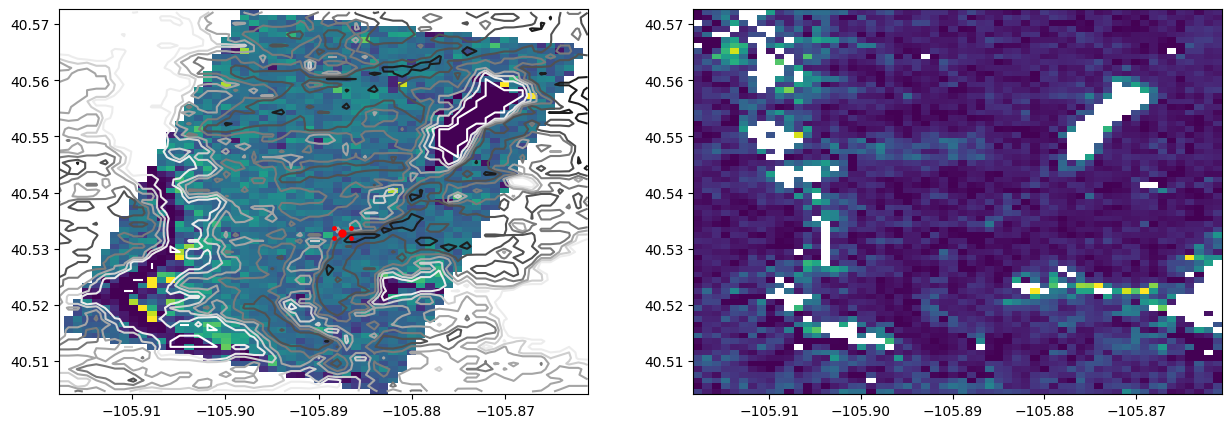

In [80]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].pcolormesh(ds.x, ds.y, ds['lidar-sd'], vmin = 0, vmax = 4)
ax[0].contour(ds.x, ds.y, ds['fcf'], vmin = 0, vmax = 1, cmap = 'Greys')
ax[0].plot(snotel_x, snotel_y, 'r.', markersize = 10)
ax[0].plot(snotel_x-tol, snotel_y-tol, 'r.', markersize = 5)
ax[0].plot(snotel_x-tol, snotel_y+tol, 'r.', markersize = 5)
ax[0].plot(snotel_x+tol, snotel_y+tol, 'r.', markersize = 5)
ax[0].plot(snotel_x+tol, snotel_y-tol, 'r.', markersize = 5)

ax[1].pcolormesh(ds.x, ds.y, ds.sel(time = closest_ts).snow_depth, vmin = 0, vmax = 4)

In [81]:
lidar_depth = ds['lidar-sd'].sel(x = slice(snotel_x - tol, snotel_x + tol), y = slice(snotel_y + tol, snotel_y - tol)).mean()

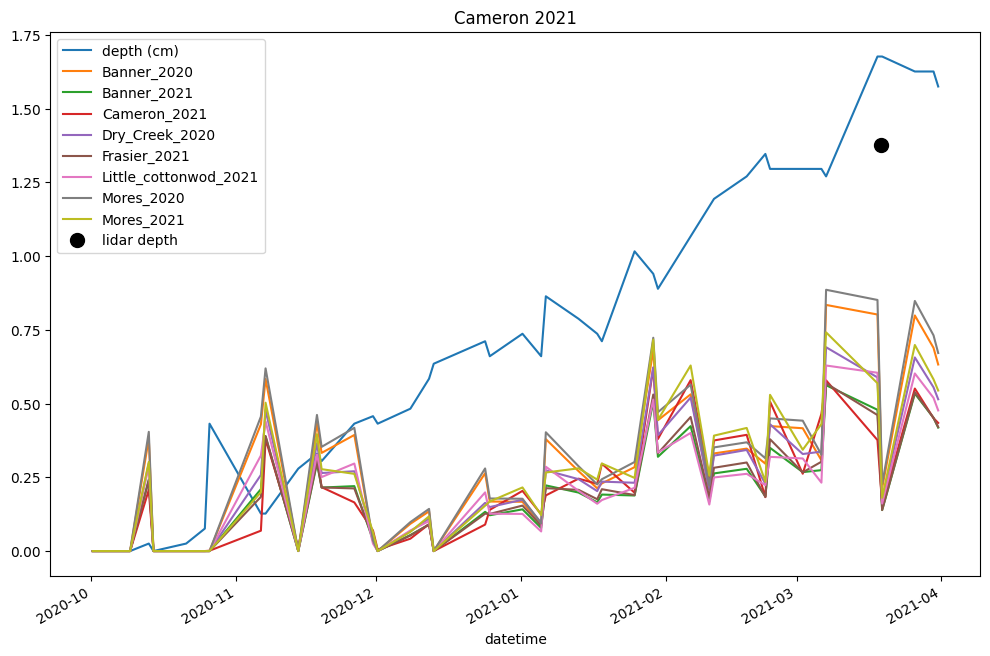

In [82]:
fig,ax = plt.subplots(figsize = (12,8))
snotel.dropna(subset = ['Banner_2020'])[['depth (cm)','Banner_2020', 'Banner_2021', 'Cameron_2021', 'Dry_Creek_2020', 'Frasier_2021', 'Little_cottonwod_2021', 'Mores_2020', 'Mores_2021','datetime']].set_index('datetime').plot(ax = ax, linestyle = '-')
plt.plot(closest_ts, lidar_depth,'k.', markersize = 20, label = 'lidar depth')
plt.title('Cameron 2021')
plt.savefig('cameron_2021.png')
plt.legend()